# Bachelor Thesis

## LoRa Time on Air

In [1]:
class LoraConf:
    preamble_len = 12
    crc = True
    sf = 7 # [7..12]
    cr = 1 # [0..4]: coding-rate is calculated as follows: 4/(4+cr)
    bw = 125_000
    def __init__(self, preamble_len = 12, crc = True, sf = 7, cr = 1, bw = 125_000):
        self.preamble_len = preamble_len
        self.crc = crc
        self.sf = sf
        self.cr = cr
        self.bw = bw

lora_conf = LoraConf(8, True, 7, 1, 125_000)

Implement time on air (ToA) calculation as described in [STM32WL5X reference manual](https://www.st.com/content/ccc/resource/technical/document/reference_manual/group0/34/ea/c6/91/75/6f/45/27/DM00451556/files/DM00451556.pdf/jcr:content/translations/en.DM00451556.pdf)

In [2]:
def ceil(frac, base):
    return ((frac // base) + 1 ) * base

def lora_time_on_air(lora_conf, user_payload_bytes):
    nb_payload_symbols_frac = ((user_payload_bytes * 8 + int(lora_conf.crc) * 16 - 4 * (lora_conf.sf - 7)) * (4 + lora_conf.cr)) / (4 * lora_conf.sf)
    nb_payload_symbols = ceil(nb_payload_symbols_frac, lora_conf.cr + 4)
    return (lora_conf.preamble_len + nb_payload_symbols + 4.25 + 8) * (2**lora_conf.sf / lora_conf.bw)

### ToA calculations

#### Ping_t
```c
typedef struct {
    uint8_t device_id;
    uint_t packet_id;
} Ping_t;
```
#### AnchorResponse_t
```c
typedef struct {
    char anchor_id;
    int16_t recv_rssi;
} AnchorResponse_t;
```
#### Ack_t
```c
typedef struct {
    char anchor_id;
    uint8_t packet_id;
} Ack_t;
```

In [3]:
print(f"ToA(Ping_t) = {lora_time_on_air(lora_conf, 2) * 1000}ms")
print(f"ToA(AnchorResponse_t) = {lora_time_on_air(lora_conf, 3) * 1000}ms")
print(f"ToA(Ack_t) = {lora_time_on_air(lora_conf, 2) * 1000}ms")

ToA(Ping_t) = 30.976ms
ToA(AnchorResponse_t) = 30.976ms
ToA(Ack_t) = 30.976ms


## Battery Lifetime

### Device configuration

In [4]:
cr2 = 850 #mAh
little_lipo = 3500 #mAh
big_lipo = 40000 #mAh
tx_power_draw = 135 #mA
rx_power_draw = 42.5 #mA
idle_power_draw = 14.5 #mA
tx_time = 40*2 #ms
rx_time = 400 #ms

In [5]:
def power_draw(tx_power, rx_power, idle_power, t_tx, t_rx):
    return (tx_power * (t_tx / 1000)) + (rx_power * (t_rx / 1000)) + (idle_power * ((1000 - t_rx - t_rx) / 1000))

# capacity in mAh, power_draw in mA
def calc_bat_time(capacity, power_draw):
    return capacity / power_draw / 24

In [6]:
datasheet_power_draw = power_draw(tx_power=23.5, rx_power=8.9, idle_power=0.4, t_tx=40, t_rx=200)
print(f"cr2 = {calc_bat_time(cr2, datasheet_power_draw)} days")
print(f"little lipo = {calc_bat_time(little_lipo, datasheet_power_draw)} days")
print(f"big lipo = {calc_bat_time(big_lipo, datasheet_power_draw)} days")

actual_power_draw = power_draw(tx_power=135, rx_power=42.5, idle_power=14.5, t_tx=40*2, t_rx=400)
print(f"actual = {actual_power_draw}")

cr2 = 11.965090090090092 days
little lipo = 49.26801801801802 days
big lipo = 563.063063063063 days
actual = 30.700000000000003


## Helper functions

### Convert MCU timestamp to Python datetime

In [7]:
from datetime import datetime, timedelta

def convert_timestamp(ts_str: str) -> datetime:
    # Remove the trailing 's' and split into seconds and milliseconds
    seconds, milliseconds = ts_str.split('s')
    # Create a datetime object
    return datetime.min + timedelta(seconds=int(seconds), milliseconds=int(milliseconds))

### Trilateration function

In [8]:
import numpy as np

def trilaterate(anchor_positions, distances):
    """
    Estimate the position of a point using trilateration.
    
    :param anchor_positions: List of (x, y, z) coordinates of the anchors
    :param distances: List of distances from each anchor to the point
    :return: Estimated (x, y, z) position of the point
    """
    # Ensure we have exactly 3 anchor positions and distances
    if len(anchor_positions) != 3 or len(distances) != 3:
        raise ValueError("Trilateration requires exactly 3 anchor positions and distances")
    
    # Extract anchor positions
    P1, P2, P3 = np.array(anchor_positions)
    
    # Calculate the vectors between anchors
    P21 = P2 - P1
    P31 = P3 - P1
    
    # Create the matrix A and vector b for the equation Ax = b
    A = np.array([
        [2*P21[0], 2*P21[1]],
        [2*P31[0], 2*P31[1]]
    ])
    
    b = np.array([
        distances[0]**2 - distances[1]**2 + np.dot(P2, P2) - np.dot(P1, P1),
        distances[0]**2 - distances[2]**2 + np.dot(P3, P3) - np.dot(P1, P1)
    ])
    
    # Solve the system of equations
    try:
        x = np.linalg.lstsq(A, b, rcond=None)[0]
    except np.linalg.LinAlgError:
        raise ValueError("Unable to solve the trilateration problem. The anchor positions may be collinear.")
    
    # The solution is relative to P1, so add P1 to get the final position
    
    return x

def circle_intersect(c0, r0, c1, r1):
        c0 = np.array(c0)
        c1 = np.array(c1)
        v = c1 - c0
        d = np.linalg.norm(v)
    
        if (d > (r0 + r1)) or d == 0:
            return None
        
        u = v/np.linalg.norm(v)
        xvec = c0 + (d**2 - r1**2 + r0**2)*u/(2*d)
    
        uperp = np.array([u[1], -u[0]])
        tmp =(-d+r1-r0)*(-d-r1+r0)*(-d+r1+r0)*(d+r1+r0)
        if tmp < 0:
            return None
        a = np.sqrt(tmp)/d
        return (xvec + a*uperp/2, xvec - a*uperp/2)

def nearer_point(ps, p_orig):
    d1 = np.linalg.norm(ps[0] - p_orig)
    d2 = np.linalg.norm(ps[1] - p_orig)
    if d1 < d2:
        return ps[0]
    else:
        return ps[1]

def intersection_triangle(s12, s13, s23, p1, p2, p3):
    """Always choose the intersection point that is closest to the anchor node not involved in the
    circle intersection.
    """
    s12 = [np.array(p) for p in s12]
    s13 = [np.array(p) for p in s13]
    s23 = [np.array(p) for p in s23]

    triangle = []
    triangle.append(nearer_point(s12, p3))
    triangle.append(nearer_point(s13, triangle[0]))

    d11, d12 = [np.linalg.norm(s23[0] - triangle[0]), np.linalg.norm(s23[0] - triangle[1])]
    d21, d22 = [np.linalg.norm(s23[1] - triangle[0]), np.linalg.norm(s23[1] - triangle[1])]

    if d11 < d21 and d12 < d22:
        triangle.append(s23[0])
    elif d11 >= d21 and d12 >= d22:
        triangle.append(s23[1])
    else:
        if np.abs(d11) + np.abs(d12) < np.abs(d21) + np.abs(d22):
            triangle.append(s23[0])
        else:
            triangle.append(s23[1])

    return triangle

def triangle_center(a, b, c):
    return [(a[0] + b[0] + c[0]) / 3, (a[1] + b[1] + c[1]) / 3]

def trilaterate_with_uncertainty(anchor_positions, distances, distance_uncertainties):
    # Ensure we have exactly 3 anchor positions and distances
    if len(anchor_positions) != 3 or len(distances) != 3:
        raise ValueError("Trilateration requires exactly 3 anchor positions and distances")

    P1, P2, P3 = np.array(anchor_positions)

    S12 = circle_intersect(anchor_positions[0], distances[0], anchor_positions[1], distances[1])
    if S12 is None or np.isnan(S12).any():
        return None
    S13 = circle_intersect(anchor_positions[0], distances[0], anchor_positions[2], distances[2])
    if S13 is None or np.isnan(S13).any():
        return None
    S23 = circle_intersect(anchor_positions[1], distances[1], anchor_positions[2], distances[2])
    if S23 is None or np.isnan(S23).any():
        return None

    
    A, B, C = intersection_triangle(S12, S13, S23, P1, P2, P3)

    m_x, m_y = triangle_center(A, B, C)

    return {
        'estimated': np.array([m_x, m_y]),
        'triangle': [A, B, C],
        'intersections': [S12, S13, S23],
    }


## Evaluation

In [9]:
from typing import List, Union, Dict
import pandas as pd
from dataclasses import dataclass
from datetime import datetime

### CSV V1 parsing

In [10]:
@dataclass
class MsgV1:
    experiment: str
    distance: float
    timestamp: datetime
    anchor_id: int
    recv_rssi: int

In [11]:
import pandas as pd
from pathlib import Path
import re

def find_data_start(file_path):
    """
    Find the line number where the CSV data actually starts by looking for
    the first line that starts with a number
    
    Parameters:
    file_path (Path): Path to the CSV file
    
    Returns:
    int: Line number where data starts
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        data_start = 0
        while True:
            line = f.readline()
            if not line:
                break;
            elif re.match(r"^\d+", line):
                break;
            else:
                data_start += 1
        f.close()
        return data_start

def parse_csv_v1(file_path: str) -> pd.DataFrame:
    """
    Parse all CSV files in a specified directory (non-recursive).
    Adds directory information to the resulting DataFrame.
    
    Parameters:
    directory (str): Directory path containing CSV files
    
    Returns:
    pandas.DataFrame: Combined DataFrame with all CSV data and directory information
    """
    file_path = Path(file_path)
    data_start = find_data_start(file_path)

    # Read CSV file
    df = pd.read_csv(file_path, header=None, index_col=False, skiprows=data_start, names=['timestamp', 'anchor_id', 'recv_rssi_dbm'])

    
    # Remove trailing colon from timestamp and convert to datetime
    df['timestamp'] = df['timestamp'].str.split(":").str[0].apply(convert_timestamp)
    df['anchor_id'] = (df['anchor_id']
                    .apply(str)
                    .str.replace(r"^1$", "A", regex=True)
                    .str.replace(r"^2$", "B", regex=True)
                    .str.replace(r"^3$", "C", regex=True))
    
    # Add file and directory information
    dist = file_path.name.rstrip(".csv").strip()
    if re.match(r"^\d+cm$", dist) != None:
        df['distance_m'] = float(dist.rstrip("cm")) * 0.01
    elif re.match(r"^\d+m$", dist) != None:
        df['distance_m'] = float(dist.rstrip("m"))
    else:
        df['distance_m'] = 0.0
        
    df['experiment'] = str(file_path.parent.name).lstrip("experiment")

    return df

def df_to_msgs_v1(df: pd.DataFrame) -> List[MsgV1]:
    messages = []
    for _, row in df.iterrows():
        messages.append(MsgV1(row['experiment'], row['distance_m'], row['timestamp'], row['anchor_id'], row['recv_rssi_dbm']))
    return messages

def print_msgs_v1(messages: List[MsgV1]):
    for msg in messages:
        print(f"DistMsg: Experiment={msg.experiment}, Distance={msg.distance}, Timestamp={msg.timestamp}, Anchor ID={msg.anchor_id}, RSSI={msg.recv_rssi}")


### CSV V2 Parsing

In [12]:
@dataclass
class PingMessage:
    timestamp: datetime
    direction: str
    device_id: str
    packet_id: int

@dataclass
class AnchorResponseMessage:
    timestamp: datetime
    direction: str
    anchor_id: str
    packet_id: int
    recv_rssi: int

@dataclass
class AckMessage:
    timestamp: datetime
    direction: str
    receiver_id: str
    packet_id: int

MsgV2 = Union[PingMessage, AnchorResponseMessage, AckMessage]

In [13]:
def parse_csv_v2(file_path: str) -> pd.DataFrame:
    # Read CSV file using pandas
    file_path = Path(file_path)
    df = pd.read_csv(file_path, header=None, index_col=False, names=['timestamp', 'direction', 'message_type', 'id', 'packet_id', 'recv_rssi'])

    
    # Remove trailing colon from timestamp and convert to datetime
    df['timestamp'] = df['timestamp'].str[:-1].apply(convert_timestamp)
    df['direction'] = df['direction'].str.strip()
    df['message_type'] = df['message_type'].str.strip()
    df['id'] = df['id'].str.strip()

    # Add file and directory information
    dist = file_path.name.rstrip(".csv").strip()
    if re.match(r"^\d+cm$", dist) != None:
        df['distance_m'] = float(dist.rstrip("cm")) * 0.01
    elif re.match(r"^\d+m$", dist) != None:
        df['distance_m'] = float(dist.rstrip("m"))
    elif re.match(r"^\d+m_\d+\.\d+m$", dist) != None:
        d,derr = dist.split("_")
        df['distance_m'] = float(d.rstrip("m"))
        df['error_distance_m'] = float(derr.rstrip("m"))
    else:
        df['distance_m'] = 0.0
        
    df['experiment'] = str(file_path.parent.name).lstrip("experiment")

    return df
    
def df_to_msgs_v2(df: pd.DataFrame):
    messages = []
    
    for _, row in df.iterrows():
        if row['message_type'] == 'Ping':
            messages.append(PingMessage(row['timestamp'], row['direction'], row['id'], int(row['packet_id'])))
        elif row['message_type'] == 'AnchorResponse':
            messages.append(AnchorResponseMessage(row['timestamp'], row['direction'], row['id'], int(row['packet_id']), int(row['recv_rssi'])))
        elif row['message_type'] == 'Ack':
            messages.append(AckMessage(row['timestamp'], row['direction'], row['id'], int(row['packet_id'])))

    return messages

def print_msgs_v2(messages: List[MsgV2]):
    for msg in messages:
        if isinstance(msg, PingMessage):
            print(f"Ping: Timestamp={msg.timestamp}, Direction={msg.direction}, Device ID={msg.device_id}, Packet ID={msg.packet_id}")
        elif isinstance(msg, AnchorResponseMessage):
            print(f"AnchorResponse: Timestamp={msg.timestamp}, Direction={msg.direction}, Anchor ID={msg.anchor_id}, Packet ID={msg.packet_id}, RSSI={msg.recv_rssi}")
        elif isinstance(msg, AckMessage):
            print(f"Ack: Timestamp={msg.timestamp}, Direction={msg.direction}, Receiver ID={msg.receiver_id}, Packet ID={msg.packet_id}")

def analyze_df_v2(df):
    print("Data Summary:")
    print(df.describe())
    
    print("\nMessage Type Distribution:")
    print(df['message_type'].value_counts())
    
    print("\nDirection Distribution:")
    print(df['direction'].value_counts())
    
    if 'recv_rssi' in df.columns:
        print("\nRSSI Statistics:")
        print(df['recv_rssi'].describe())
    
    print("\nTimestamp Range:")
    print(f"Start: {df['timestamp'].min()}")
    print(f"End: {df['timestamp'].max()}")
    print(f"Duration: {df['timestamp'].max() - df['timestamp'].min()}")

### Function for parsing all CSV files of a distance estimation experiment

In [14]:
def parse_dist_exp_dir(dir_path: str, csv_version: str) -> pd.DataFrame:
    # Convert directory to Path object for better path handling
    dir_path = Path(dir_path)
    
    # List to store all DataFrames
    dfs = []
    
    # Get all CSV files in the directory (non-recursive)
    csv_files = [f for f in dir_path.iterdir() if f.is_file() and f.suffix.lower() == '.csv']
    
    for file_path in csv_files:
        try:
            if csv_version == 'v1':
                dfs.append(parse_csv_v1(file_path))
            elif csv_version == 'v2':
                dfs.append(parse_csv_v2(file_path))
            else:
                raise Exception(f"Unknown `csv_type` \"{csv_version}\"")
        except Exception as e:
            print(f"Error processing {file_path.name}: {str(e)}")
            continue
    
    # Combine all DataFrames
    if dfs:
        combined_df = pd.concat(dfs, ignore_index=True)
        if csv_version == "v2":
            combined_df = (combined_df
                           .where(combined_df['message_type'] == 'AnchorResponse')
                           .rename(columns={ 'id': "anchor_id", 'recv_rssi': "recv_rssi_dbm"})
                           [['timestamp', 'anchor_id', 'recv_rssi_dbm', 'distance_m', 'experiment']])
        return combined_df
    else:
        return pd.DataFrame()  # Return empty DataFrame if no CSVs found

### Distance estimation

In [15]:
@dataclass
class Experiment:
    id: str
    version: str

experiments = [Experiment(id, 'v1') for id in ['01_2', '02_1', '02_2']]
experiments += [Experiment(id, 'v2') for id in ['07']]
dist_df = pd.concat([parse_dist_exp_dir(f"../../data/experiment{e.id}", e.version) for e in experiments], ignore_index=True)

MIN_DISTANCE_M = 1.0
dist_df = dist_df[dist_df['distance_m'] >= MIN_DISTANCE_M]
dist_msgs = df_to_msgs_v1(dist_df)
print_msgs_v1(dist_msgs)


DistMsg: Experiment=01_2, Distance=50.0, Timestamp=0001-01-01 00:00:03.622000, Anchor ID=A, RSSI=-52.0
DistMsg: Experiment=01_2, Distance=50.0, Timestamp=0001-01-01 00:00:04.021000, Anchor ID=A, RSSI=-53.0
DistMsg: Experiment=01_2, Distance=50.0, Timestamp=0001-01-01 00:00:04.420000, Anchor ID=A, RSSI=-53.0
DistMsg: Experiment=01_2, Distance=50.0, Timestamp=0001-01-01 00:00:04.820000, Anchor ID=A, RSSI=-53.0
DistMsg: Experiment=01_2, Distance=50.0, Timestamp=0001-01-01 00:00:05.219000, Anchor ID=A, RSSI=-53.0
DistMsg: Experiment=01_2, Distance=50.0, Timestamp=0001-01-01 00:00:05.619000, Anchor ID=A, RSSI=-53.0
DistMsg: Experiment=01_2, Distance=50.0, Timestamp=0001-01-01 00:00:06.018000, Anchor ID=A, RSSI=-54.0
DistMsg: Experiment=01_2, Distance=50.0, Timestamp=0001-01-01 00:00:06.417000, Anchor ID=A, RSSI=-54.0
DistMsg: Experiment=01_2, Distance=50.0, Timestamp=0001-01-01 00:00:06.817000, Anchor ID=A, RSSI=-54.0
DistMsg: Experiment=01_2, Distance=50.0, Timestamp=0001-01-01 00:00:07.21

### Groupby experiment and calculate RSSI average

In [16]:
grouped = dist_df.groupby(['experiment', 'distance_m'], as_index=False)


for pos, group in grouped:
    dist_df.loc[(dist_df['experiment'] == pos[0]) & (dist_df['distance_m'] == pos[1]), 'mean_rssi_dbm'] = group['recv_rssi_dbm'].mean()

dist_df

,timestamp,anchor_id,recv_rssi_dbm,distance_m,experiment,mean_rssi_dbm
0,0001-01-01 00:00:03.622000,A,-52.0,50.0,01_2,-53.070968
1,0001-01-01 00:00:04.021000,A,-53.0,50.0,01_2,-53.070968
2,0001-01-01 00:00:04.420000,A,-53.0,50.0,01_2,-53.070968
3,0001-01-01 00:00:04.820000,A,-53.0,50.0,01_2,-53.070968
4,0001-01-01 00:00:05.219000,A,-53.0,50.0,01_2,-53.070968
...,...,...,...,...,...,...
8015,0001-01-01 00:25:48.093000,A,-66.0,160.0,07,-65.978723
8018,0001-01-01 00:25:49.093000,A,-67.0,160.0,07,-65.978723
8021,0001-01-01 00:25:50.093000,A,-67.0,160.0,07,-65.978723
8024,0001-01-01 00:25:51.093000,A,-67.0,160.0,07,-65.978723


/tmp/ipykernel_115538/1905404600.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


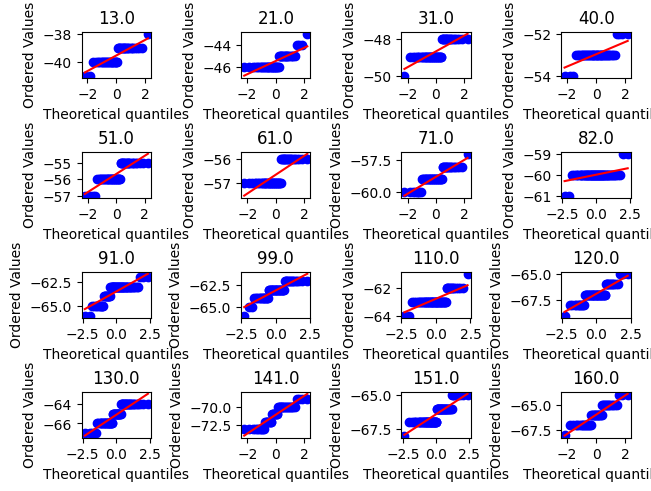

In [34]:
import numpy as np 
import matplotlib.pyplot as plt
import pylab 
import scipy.stats as stats


fig, axs = plt.subplots(4, 4, layout='constrained')
axs = axs.flatten()

idx = 0
exp = '07'
for pos, group in dist_df[dist_df['experiment'] == exp].groupby('distance_m', as_index=False):
    ax = axs[idx]
    measurements = dist_df[(dist_df['experiment'] == exp) & (dist_df['distance_m'] == pos)] [['recv_rssi_dbm']].to_numpy().flatten()
    stats.probplot(measurements, dist="norm", plot=ax)
    ax.set_title(pos)
    idx += 1
fig.show()

### Aggregate dist_df

In [18]:
agg_dist_df = dist_df[['experiment', 'distance_m', 'mean_rssi_dbm']].drop_duplicates().reset_index(drop=True)
agg_dist_df

,experiment,distance_m,mean_rssi_dbm
0,01_2,50.0,-53.070968
1,01_2,45.0,-51.318471
2,01_2,40.0,-48.601351
3,01_2,35.0,-47.870130
4,01_2,30.0,-45.920000
5,01_2,25.0,-47.241830
6,01_2,20.0,-39.213333
7,01_2,15.0,-38.469799
8,01_2,10.0,-36.973333
9,01_2,5.0,-32.184713


### Build log-normal models from experiment data

In [19]:
from sklearn.linear_model import LinearRegression
import math

@dataclass
class LogModel:
    slope: np.float64
    intercept: np.float64
    rel_error: np.float64
    std_rel_error: np.float64

    def error(self):
        return self.rel_error + self.std_rel_error

def log_normal_model(dists, rssis):
    """Calculate the log-normal model for a given set of distances and RSSI values"""
    X = np.array([math.log(d, 10) for d in dists]).reshape(-1, 1)
    y = np.array(rssis)
    reg = LinearRegression().fit(X, y)
    return (*reg.coef_, reg.intercept_)

models = {}

for experiment, group in agg_dist_df.groupby('experiment'):
    (slope, intercept) = log_normal_model(group['distance_m'], group['mean_rssi_dbm'])
    models[experiment] = LogModel(slope, intercept, 0.0, 0.0)
    print()
    print(f"experiment{experiment}")
    print(f"slope={slope}")
    print(f"intercept={intercept}")



experiment01_2
slope=-20.872737094375886
intercept=-15.804954850628874

experiment02_1
slope=-21.331254524289214
intercept=-12.80286397407681

experiment02_2
slope=-17.557665052756633
intercept=-17.63984326850011

experiment07
slope=-26.444129185490443
intercept=-10.146522159494111


### Calculate distance from RSSI with log-normal path-loss model

In [20]:
def rssi_to_distance(rssi: np.float64, experiment: str):
    return 10**((rssi-models[experiment].intercept)/models[experiment].slope)

def rssi_to_distance_bounds(rssi: np.float64, experiment: str):
    m = models[experiment]
    mid = 10**((rssi-m.intercept)/m.slope)
    low = mid - (mid * m.error())
    high = mid + (mid * m.error())
    return [low, mid, high]

### Analyze model error and visualizations

In [21]:
agg_dist_df['estimated_distance_m'] = agg_dist_df.apply(lambda row: rssi_to_distance(row['mean_rssi_dbm'], row['experiment']), axis=1)
agg_dist_df['error_dist_m'] = agg_dist_df['estimated_distance_m'] - agg_dist_df['distance_m']
agg_dist_df['rel_error_dist'] = agg_dist_df['error_dist_m'] / agg_dist_df['distance_m']

groupby_exp = agg_dist_df.groupby('experiment')
max_error_df = groupby_exp['error_dist_m'].max().rename('max_error_m')
min_error_df = groupby_exp['error_dist_m'].min().rename('min_error_m')
mean_rel_error_df = groupby_exp['rel_error_dist'].mean().rename('mean_rel_error')
std_rel_error_df = groupby_exp['rel_error_dist'].std().rename('std_rel_error')
agg_dist_df = pd.merge(agg_dist_df, max_error_df, on="experiment", how="left")
agg_dist_df = pd.merge(agg_dist_df, min_error_df, on="experiment", how="left")
agg_dist_df = pd.merge(agg_dist_df, std_rel_error_df, on="experiment", how="left")
agg_dist_df = pd.merge(agg_dist_df, mean_rel_error_df, on="experiment", how="left")

# store standardized relative error in models for later use
for exp, m in models.items():
    m.rel_error = agg_dist_df[agg_dist_df['experiment'] == exp]['mean_rel_error'].iloc[0]
    m.std_rel_error = agg_dist_df[agg_dist_df['experiment'] == exp]['std_rel_error'].iloc[0]

agg_dist_df

,experiment,distance_m,mean_rssi_dbm,estimated_distance_m,error_dist_m,rel_error_dist,max_error_m,min_error_m,std_rel_error,mean_rel_error
0,01_2,50.0,-53.070968,61.008699,11.008699,0.220174,11.008699,-6.772401,0.196734,0.018337
1,01_2,45.0,-51.318471,50.284107,5.284107,0.117425,11.008699,-6.772401,0.196734,0.018337
2,01_2,40.0,-48.601351,37.261059,-2.738941,-0.068474,11.008699,-6.772401,0.196734,0.018337
3,01_2,35.0,-47.870130,34.373426,-0.626574,-0.017902,11.008699,-6.772401,0.196734,0.018337
4,01_2,30.0,-45.920000,27.720004,-2.279996,-0.076000,11.008699,-6.772401,0.196734,0.018337
5,01_2,25.0,-47.241830,32.071654,7.071654,0.282866,11.008699,-6.772401,0.196734,0.018337
6,01_2,20.0,-39.213333,13.227599,-6.772401,-0.338620,11.008699,-6.772401,0.196734,0.018337
7,01_2,15.0,-38.469799,12.185931,-2.814069,-0.187605,11.008699,-6.772401,0.196734,0.018337
8,01_2,10.0,-36.973333,10.331515,0.331515,0.033151,11.008699,-6.772401,0.196734,0.018337
9,01_2,5.0,-32.184713,6.091779,1.091779,0.218356,11.008699,-6.772401,0.196734,0.018337


### Export analysis to CSV

In [22]:
# export the aggregated error and models of the experiments
dist_agg_export = agg_dist_df[['experiment', 'max_error_m', 'min_error_m', 'std_rel_error', 'mean_rel_error']].drop_duplicates()
dist_agg_export['slope'] = dist_agg_export.apply(lambda row: models[row['experiment']].slope, axis=1)
dist_agg_export['intercept'] = dist_agg_export.apply(lambda row: models[row['experiment']].intercept, axis=1)
dist_agg_export.to_csv("../../text/data/distance_aggregated_error.csv")

# export the experiment with the best error
best_exp = dist_agg_export.loc[dist_agg_export['std_rel_error'].idxmin()]['experiment']

for e in experiments:
    dist_export = agg_dist_df[agg_dist_df['experiment'] == e.id]
    dist_export.to_csv(f"../../text/data/{e.id}.csv")

### Visualization

In [23]:
import matplotlib.pyplot as plt
import matplotlib
#matplotlib.use('svg')

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ['Source Sans 3']
plt.rcParams["font.size"] = 13

plt.style.use("default")

def dist_visualize(viz_df):
    """
    Visualize distance estimation (RSSI vs distance).

    Parameters:
    viz_df (pd.DataFrame): Must include 'mean_rssi_dbm', 'distance_m' and 'experiment' column. The first two are used for the x- and y-values of the graph.
    """
    xs = viz_df['mean_rssi_dbm']
    ys = viz_df['distance_m']
    exp = viz_df['experiment'].iloc[0]
    fig = plt.figure(figsize=(8, 5))

    plt.xlabel("RSSI [dBm]")
    plt.ylabel("Distance [m]")


    xstart = math.ceil(max(xs)) + 5
    xend = math.floor(min(xs)) - 1
    plt.xlim(xstart, xend)

    plt.scatter(
        xs, ys,
        marker=matplotlib.markers.MarkerStyle('x').scaled(1.8),
        zorder=10,
        label="measured")


    step_xs = range(xstart, xend, -1)
    step_ys_min = [rssi_to_distance(x, exp) for x in step_xs]
    step_ys_max = [rssi_to_distance(x-1, exp) for x in step_xs]
    plt.vlines(
        step_xs, step_ys_min, step_ys_max,
        colors='red',
        zorder=5,
        label="quantization error"
        )

    est_xs = step_xs
    est_ys = [rssi_to_distance(x, exp) for x in est_xs]

    plt.plot(
        est_xs,
        est_ys,
        color='black',
        zorder=10,
        label="estimated"
    )

    # TODO insert estimated_interpolated

    plt.legend(loc="upper left")

    plt.savefig(f"../../text/assets/{exp}.svg")

In [24]:
dist_visualize(agg_dist_df[agg_dist_df['experiment'] == best_exp])
dist_visualize(agg_dist_df[agg_dist_df['experiment'] == '07'])

In [25]:
d_m_50 = rssi_to_distance(-50, best_exp)
d_m_51 = rssi_to_distance(-51, best_exp)

print(f"d@-50dBm={d_m_50}")
print(f"d@-49dBm={d_m_51}")
print(f"diff={d_m_51 - d_m_50}")

d@-50dBm=55.43520692438698
d@-49dBm=61.75402099545475
diff=6.31881407106777


### Localization

In [26]:
def group_anchor_responses(messages: List[MsgV2]) -> Dict[int, List[AnchorResponseMessage]]:
    anchor_responses = {}
    for msg in messages:
        if isinstance(msg, AnchorResponseMessage) and msg.direction == 'RX':
            if msg.packet_id not in anchor_responses:
                anchor_responses[msg.packet_id] = []
            anchor_responses[msg.packet_id].append(msg)
    return anchor_responses

def print_grouped_responses(grouped_responses: Dict[int, List[AnchorResponseMessage]]):
    for packet_id, responses in grouped_responses.items():
        print(f"\nPacket ID: {packet_id}")
        for response in responses:
            print(f"  Anchor ID: {response.anchor_id}, RSSI: {response.recv_rssi}, Timestamp: {response.timestamp}")

### Transform coordinates

In [27]:
from pyproj import Transformer

def dms_to_dd(dms):
    d, m , s, *rest = dms.split(' ')
    return np.float64(d) + np.float64(m) / 60 + np.float64(s) / 3600

gps_to_cart = Transformer.from_crs("EPSG:4326", "EPSG:3395")

class Anchor:
    id: str
    lat: np.float64
    long: np.float64
    x: np.float64
    y: np.float64

    def __init__(self, id: str, lat: str, long: str):
        self.id = id
        self.lat = dms_to_dd(lat)
        self.long = dms_to_dd(long)
        self.x, self.y = gps_to_cart.transform(self.lat, self.long)


class ActualPosition:
    id: str
    lat: np.float64
    long: np.float64
    err_horiz: np.float64
    err_vert: np.float64
    x: np.float64
    y: np.float64

    def __init__(self, id: str, lat: str, long: str, err_horiz: np.float64, err_vert: np.float64):
        self.id = id
        self.lat = dms_to_dd(lat)
        self.long = dms_to_dd(long)
        self.err_horiz = err_horiz
        self.err_horiz = err_horiz
        self.x, self.y = gps_to_cart.transform(self.lat, self.long)

### Read all CSV position data

In [28]:

positions = [['04', 'pos1'], ['05', 'pos2'], ['06', 'pos3']]
pos_coords = {
    'pos1': ActualPosition('pos1', 
                   '51 20 59.862881', 
                   '12 21 46.765835', 
                   4, 3, ),
    'pos2': ActualPosition('pos2', 
                    '51 20 56.819335', 
                    '12 21 48.025052', 
                    5, 3,),
    'pos3': ActualPosition('pos3', 
                   '51 20 58.146686', 
                   '12 21 50.252539', 
                   4, 3,),
}

dfs = []

for p in positions:
    file_path = f"../../data/experiment{p[0]}/{p[1]}.csv"  # Replace with the actual path to your CSV file
    df = parse_csv_v2(file_path)
    df['position'] = p[1]
    dfs.append(df)

pos_df = pd.concat(dfs, ignore_index=True)

### Only analyze received AnchorResponse packets

In [29]:
pos_df = pos_df[(pos_df['message_type'] == 'AnchorResponse') & (pos_df['direction'] == 'RX')]

### Calculate average RSSI per position per anchor

In [30]:
from scipy import stats

grouped_by_pos = pos_df.groupby(['position', 'id'], as_index=False)

for pos, group in grouped_by_pos:
    group = group[(np.abs(stats.zscore(group['recv_rssi'])) < 1)] # remove outliers by excluding all RSSI values bigger than one standard deviation
    pos_df.loc[(pos_df['position'] == pos[0]) & (pos_df['id'] == pos[1]), 'mean_rssi_dbm'] = group['recv_rssi'].mean()

pos_df

,timestamp,direction,message_type,id,packet_id,recv_rssi,distance_m,experiment,position,mean_rssi_dbm
1,0001-01-01 00:02:17.092000,RX,AnchorResponse,C,137,-59.0,0.0,04,pos1,-69.525000
3,0001-01-01 00:02:17.157000,RX,AnchorResponse,B,137,-69.0,0.0,04,pos1,-63.483871
5,0001-01-01 00:02:17.222000,RX,AnchorResponse,A,137,-85.0,0.0,04,pos1,-80.657143
8,0001-01-01 00:02:18.092000,RX,AnchorResponse,C,138,-61.0,0.0,04,pos1,-69.525000
10,0001-01-01 00:02:18.157000,RX,AnchorResponse,B,138,-65.0,0.0,04,pos1,-63.483871
...,...,...,...,...,...,...,...,...,...,...
1187,0001-01-01 00:00:55.157000,RX,AnchorResponse,C,55,-73.0,0.0,06,pos3,-73.725000
1189,0001-01-01 00:00:55.222000,RX,AnchorResponse,A,55,-78.0,0.0,06,pos3,-80.166667
1192,0001-01-01 00:00:56.092000,RX,AnchorResponse,B,56,-65.0,0.0,06,pos3,-61.882353
1194,0001-01-01 00:00:56.157000,RX,AnchorResponse,C,56,-73.0,0.0,06,pos3,-73.725000


### Calculate position based on RSSI measurements

In [31]:
anchors = [
    Anchor('a', 
           '51 20 54.213 N', 
           '12 21 57.332 E',),
    Anchor('b', 
           '51 21 0.174 N', 
           '12 21 54.637 E',),
    Anchor('c', 
           '51 21 0.72 N',
           '12 21 43.948 E',),
]

anchor_a_precision = {'horiz': 4, 'vert': 3}
anchor_b_precision = {'horiz': 4, 'vert': 3}
anchor_c_precision = {'horiz': 4, 'vert': 3}

evaluation_experiments = ['02_1', '07']

loc_results = {}
for exp in evaluation_experiments:
    pos_results = {}
    print()
    print( '=================')
    print(f"Experiment '{exp}'")
    for pos, group in pos_df.groupby('position'):
        pos_results[pos] = {}
        print( '=================')
        print(f"Position '{pos}'")
        rssi_df = group.sort_values('id')[['id', 'mean_rssi_dbm']].drop_duplicates()
        print(rssi_df)
        pos_results[pos]['rssi'] = list(rssi_df['mean_rssi_dbm'])
        distances = list(map(lambda r: rssi_to_distance_bounds(r, exp)[1], rssi_df['mean_rssi_dbm']))
        print(f"Distances: {distances}")

        try:
            anchor_positions = [np.array([an.x, an.y]) for an in anchors]
            tri_result = trilaterate_with_uncertainty(anchor_positions, distances, [0, 0, 0])

            pos_results[pos]['anchors'] = [np.array([an.x, an.y]) for an in anchors]
            pos_results[pos]['distances'] = distances
            pos_results[pos]['actual'] = np.array([pos_coords[pos].x, pos_coords[pos].y])

            if tri_result is None:
                print("Localization impossible")
                pos_results[pos]['estimated'] = None
                pos_results[pos]['diff'] = None
            else:
                pos_results[pos]['tri_result'] = tri_result
                pos_results[pos]['estimated'] = np.array(tri_result['estimated'])
                pos_results[pos]['diff'] = np.linalg.norm(pos_results[pos]['actual'] - pos_results[pos]['estimated'])

            estimated_position = pos_results[pos]['estimated']

            # estimated_position = trilaterate(anchor_positions, distances)


            # Print output
            if estimated_position is not None:
                for an in anchors:
                    print(f"Anchor {an.id}: https://epsg.io/map#srs=3395&x={an.x}&y={an.y}&z=0&layer=streets")

                print(f"Estimated position: {estimated_position}")
                print(f"Map: https://epsg.io/map#srs=3395&x={estimated_position[0]}&y={estimated_position[1]}&z=0&layer=streets")
                print(f"Actual position: [{pos_coords[pos].x}, {pos_coords[pos].y}]")
                print(f"Map: https://epsg.io/map#srs=3395&x={pos_coords[pos].x}&y={pos_coords[pos].y}&z=0&layer=streets")
                print(f"Position difference: {pos_results[pos]['diff']}")

        except ValueError as e:
            print(f"Error: {e}")
    loc_results[exp] = pos_results



Experiment '02_1'
Position 'pos1'
    id  mean_rssi_dbm
329  A     -80.657143
255  B     -63.483871
271  C     -69.525000
Distances: [np.float64(1516.9780282020483), np.float64(237.63134208264216), np.float64(456.1516403139221)]
Localization impossible
Position 'pos2'
    id  mean_rssi_dbm
570  A     -85.000000
383  B     -80.791045
807  C     -73.150943
Distances: [np.float64(2424.2117834939095), np.float64(1539.0635566411027), np.float64(674.6707802695345)]
Localization impossible
Position 'pos3'
     id  mean_rssi_dbm
1196  A     -80.166667
1031  B     -61.882353
879   C     -73.725000
Distances: [np.float64(1438.7521265570945), np.float64(199.90573213920828), np.float64(717.799955560727)]
Localization impossible

Experiment '07'
Position 'pos1'
    id  mean_rssi_dbm
329  A     -80.657143
255  B     -63.483871
271  C     -69.525000
Distances: [np.float64(463.87375015670455), np.float64(103.9878535690364), np.float64(175.96706616395414)]
Localization impossible
Position 'pos2'
    i

### Visualize

In [32]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Wedge
#matplotlib.use('svg')

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ['Source Sans 3']
plt.rcParams["font.size"] = 13

plt.style.use("default")

def pos_visualize(experiment, position, pos_viz_dict):
    """
    Visualize distance estimation (RSSI vs distance).

    Parameters:
    viz_df (pd.DataFrame): Must include 'mean_rssi_dbm', 'distance_m' and 'experiment' column. The first two are used for the x- and y-values of the graph.
    """
    fig = plt.figure(figsize=(8, 5))
    ax = fig.gca()
    ax.set_aspect('equal')

    plt.xlabel("x [m]")
    plt.ylabel("y [m]")

    # xstart = math.ceil(max(xs)) + 5
    # xend = math.floor(min(xs)) - 1
    if experiment == '07':
        plt.xlim(-750, 750)
        plt.ylim(-750, 750)
    else:
        plt.xlim(-2200, 2200)
        plt.ylim(-2200, 2200)


    # Draw Anchor nodes
    an_xs = [a[0] for a in pos_viz_dict['anchors']]
    an_ys = [a[1] for a in pos_viz_dict['anchors']]

    plt.scatter(
        an_xs, an_ys,
        c="black",
        marker=matplotlib.markers.MarkerStyle('o').scaled(.4),
        zorder=10,
        label="Anchor nodes")
    
    for i, txt in enumerate(["A", "B", "C"]):
        ax.annotate(txt, xy=(an_xs[i], an_ys[i]), xytext=(0, 4), textcoords='offset points')

    # Draw distance circles
    alpha = 0.3
    colors = ['C0', 'C1', 'C2']
    m = models[experiment]
    dmin = [d - (d * m.error()) for d in pos_viz_dict['distances']]
    dmax = [d + (d * m.error()) for d in pos_viz_dict['distances']]
    circles_center = [plt.Circle(pos, r, color=(col, .8), fill=False) for (pos, r, col) in zip(pos_viz_dict['anchors'], pos_viz_dict['distances'], colors)]
    circles = [Wedge(pos, outer_r, 0.0, 360.0, width=(outer_r - inner_r), color=(col, alpha)) for (pos, outer_r, inner_r, col) in zip(pos_viz_dict['anchors'], dmax, dmin, colors)]

    # min_circles = [plt.Circle(pos, radius, color=(col, alpha), fill=False) for (pos, radius, col) in zip(pos_viz_dict['anchors'], dmin, colors)]
    # max_circles = [plt.Circle(pos, radius, color=(col, alpha), fill=False) for (pos, radius, col) in zip(pos_viz_dict['anchors'], dmax, colors)]
    for c in circles:
        ax.add_patch(c)
    for c in circles_center:
        ax.add_patch(c)

    # Draw estimated position
    if pos_viz_dict['estimated'] is not None:
        est_xs = [pos_viz_dict['estimated'][0]]
        est_ys = [pos_viz_dict['estimated'][1]]

        plt.scatter(
            est_xs, est_ys,
            c="red",
            marker=matplotlib.markers.MarkerStyle('x').scaled(1.8),
            zorder=10,
            label="Estimated position")
        
        triangle = plt.Polygon(pos_viz_dict['tri_result']['triangle'], color=('C4', 0.8))
        ax.add_patch(triangle)

    # Draw actual position
    actual_xs = [pos_viz_dict['actual'][0]]
    actual_ys = [pos_viz_dict['actual'][1]]

    plt.scatter(
        actual_xs, actual_ys,
        c="black",
        marker=matplotlib.markers.MarkerStyle('x').scaled(1.8),
        zorder=10,
        label="Actual position")

    plt.title(f"Experiment {experiment}")
    plt.legend(loc="upper right")

    plt.savefig(f"../../text/assets/exp{experiment}_{position}.svg")
    plt.close()

for exp, pos_results in loc_results.items():
    for pos, values in pos_results.items():
        a1, a2, a3 = values['anchors']
        if values['estimated'] is not None:
            values['estimated'] -= a1
            values['tri_result']['triangle'] = [p - a1 for p in values['tri_result']['triangle']]
        values['anchors'] = [a1 - a1, a2 - a1, a3 - a1]
        values['actual'] -= a1
        pos_visualize(exp, pos, values)

### Export Localization Data

In [33]:
@dataclass
class GPSCoord:
    lat: str
    long: str

def norm_anchors(anchor_pos):
    a1 = anchor_pos[0]
    return [an - a1 for an in anchor_pos]

anchor_positions = [np.array([an.x, an.y]) for an in anchors]
anchor_export_df = pd.DataFrame({
    'anchor_id': ['A', 'B', 'C'],
    'gps_position_long': ['12°21\'57.332"E', '12°21\'54.637"E', '12°21\'43.948"E'],
    'gps_position_lat': ['51°20\'54.213"N', '51°21\'0.174"N', '51°21\'0.72"N'],
    'cart_position_x': [an.x for an in anchors],
    'cart_position_y': [an.y for an in anchors],
    'cart_rel_position_x': [p[0] for p in norm_anchors(anchor_positions)],
    'cart_rel_position_y': [p[1] for p in norm_anchors(anchor_positions)],
})

anchor_export_df.to_csv("../../text/data/loc_anchors.csv")

In [34]:
import json

pos_export = {}

columns = ['experiment', 'position', 'anchor_id', 'rssi_dbm', 'distance_m', 'estimated_pos', 'actual_pos']
for exp, exp_results in loc_results.items():
    pos_export[exp] = {}
    for pos, pos_results in exp_results.items():
        pos_export[exp][pos] = {}
        if pos_results['estimated'] is not None:
            pos_export[exp][pos]['estimated_pos'] = list(pos_results['estimated'])
        else:
            pos_export[exp][pos]['estimated_pos'] = None
        pos_export[exp][pos]['actual_pos'] = []
        for coord in pos_results['actual']:
            pos_export[exp][pos]['actual_pos'].append(coord)
        pos_export[exp][pos]['diff_m'] = pos_results['diff']

        idx = 0
        pos_export[exp][pos]['anchors'] = []
        for an in anchors:
            d = pos_results['distances'][idx]
            derror = d * models[exp].error()
            pos_export[exp][pos]['anchors'].append([an.id, pos_results['rssi'][idx], d, derror])
            idx += 1

pos_file = open('../../text/data/pos_agg.json', 'w')
json_str = json.dumps(pos_export)
pos_file.write(json_str)
pos_file.close()